In [10]:
from PIL import Image
from PIL.TiffTags import TAGS
import re
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.transform import Affine
import numpy as np 
import cv2
import imutils
import matplotlib.pyplot as plt

Configuracion rutas de carpetas.

img_pat : Direccion de donde se toma la imagen .TIF que se va a rotar y quitar el fondo.


img_rot_path: Direccion en donde se guardaran las imagenes rotadas y sin fondo, formato .PNG de 4 canales


img_rot_TIF_path: Direccion en donde se guardaran las imagenes rasterizada, luego de la rotacion y quitarles el fondo

In [49]:
img_path = "Img/DJI_0051.TIF" 
img_rot_path = "Img_rotado/"    
img_rot_TIF_path = "Img_rotado_TIF/" 



n_imagen = img_path.split("/")[-1]
n_imagen = n_imagen.split(".")[0]
print(n_imagen)


img_rot_path = img_rot_path + n_imagen + "_rot03.PNG"
img_rot_TIF_path = img_rot_TIF_path +n_imagen + "TIF_rot03.TIF"


print(img_rot_TIF_path)
print(img_rot_path)

DJI_0051
Img_rotado_TIF/DJI_0051TIF_rot03.TIF
Img_rotado/DJI_0051_rot03.PNG


Funciones: Rotar_Imagne y Metadata de la imagen .TIF

In [50]:
def rotar_imagen(img, angulo = 0):
    # Dimensiones de la imagen original
    y, x = img.shape[:2]  # Donde 'y' son las filas y 'x' son las columnas

    capa_blanco = 255*np.ones((y, x, 1), dtype=np.int8)

    img_4 = 255*np.ones((y, x, 4), dtype=np.int8)  # Matriz de (y, x , 4)

    #print(img.shape)
    #print(capa_blanco.shape)
    #print(img_4.shape)

    img_4[:, :, 0] = img[:, :, 0]  # Blue
    img_4[:, :, 1] = img[:, :, 1]  # Green
    img_4[:, :, 2] = img[:, :, 2]  # Red
    img_4[:, :, 3] = capa_blanco[:, :, 0]


    m = imutils.rotate_bound(img_4, angulo)
    plt.imshow(m)

    # cv2.imshow("window_name", m)

    # # waits for user to press any key
    # # (this is necessary to avoid Python kernel form crashing)
    # cv2.waitKey(0)

    # # closing all open windows
    # cv2.destroyAllWindows()
    y_m, x_m = m.shape[:2]
    print(y, x)
    print(y_m, x_m)
    return m

def metadata(imagen):
    img = Image.open(imagen)
# obtenemos los Tags de la metadata y se almacenan en un diccionario
    meta_dict = {TAGS[key]: img.tag[key] for key in img.tag_v2}
    # Se imprime el diccionario para obtener la composición de los datos
    # for rec in meta_dict:
    #     print(rec, ":", meta_dict[rec])

    # Extraemos el indicador xmp
    p = meta_dict.get("XMP")
    s = p.decode("UTF-8")
    # dividimos por el salto de linea y obtenemos una lista
    div = s.split("\n")

    #eliminamos los espacios vacios 

    for ind,recorrido in enumerate(div):
        div[ind]=recorrido.strip() 
    usar = div[17]

    result = re.search(":(.*)=", div[17])
    result.group(1)

    result2 = re.search("\"(.*)\"", div[17])
    result2.group(1)

    metadiccionario = {}
    for ind,recorrido in enumerate(div):
        try:
            metadiccionario[re.search(":(.*)=", div[ind]).group(1)] = re.search("\"(.*)\"", div[ind]).group(1)
        except:
            pass

    metadiccionario = {}
    for ind,recorrido in enumerate(div):
        try:
            metadiccionario[re.search(":(.*)=", div[ind]).group(1)] = re.search("\"(.*)\"", div[ind]).group(1)
        except:
            pass

    #print(metadiccionario)
    return metadiccionario


In [ ]:
metadiccionario = metadata(img_path)

centro_x = float(metadiccionario["CalibratedOpticalCenterX"])
centro_y = float(metadiccionario["CalibratedOpticalCenterY"])
altura_vuelo = float(metadiccionario["RelativeAltitude"])
distancia_focal = float(metadiccionario["CalibratedFocalLength"])
angulo_giro = float(metadiccionario["GimbalYawDegree"])
latitud = float(metadiccionario["GpsLatitude"])
longitud = float(metadiccionario["GpsLongitude"])

resolucion = altura_vuelo/distancia_focal
print(f"Resolución = {resolucion}")

min_lon = float(metadiccionario["GpsLongitude"]) - (
    float(metadiccionario["CalibratedOpticalCenterX"]) * resolucion) / 111111
max_lon = float(metadiccionario["GpsLongitude"]) + (
    float(metadiccionario["CalibratedOpticalCenterX"]) * resolucion) / 111111
min_lat = float(metadiccionario["GpsLatitude"]) - (
    float(metadiccionario["CalibratedOpticalCenterY"]) * resolucion) / 111111
max_lat = float(metadiccionario["GpsLatitude"]) + (
    float(metadiccionario["CalibratedOpticalCenterY"]) * resolucion) / 111111


#print(min_lon, max_lon, min_lat, max_lat)


Lectura y rotacion de la imagen.

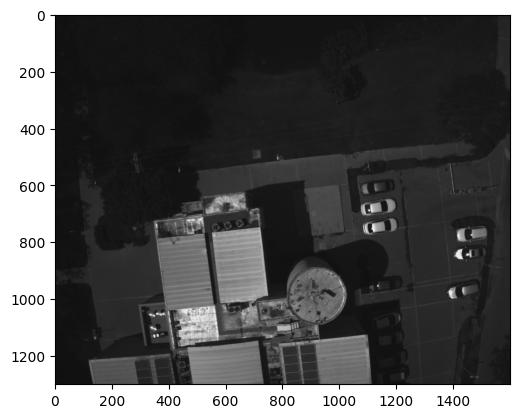

In [52]:
img_o =cv2.imread(img_path, 1) #Lectura
plt.imshow(img_o)

1300 1600
1736 1472


True

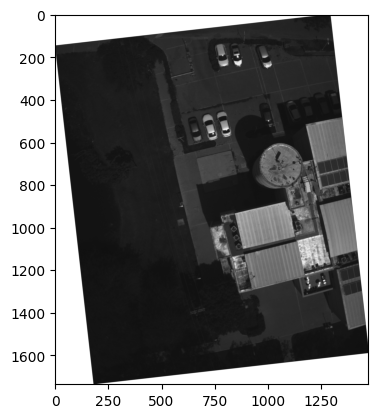

In [53]:
angulo =  (float(metadiccionario["GimbalYawDegree"])) #Calculo del angulo de rotacion
img_rot = rotar_imagen(img_o, angulo) #Img rotada y sin fondo
cv2.imwrite(img_rot_path, img_rot) #gurda la image rotada

Pasar una imagen PNG a una Raster

In [54]:

img_data = rasterio.open(img_rot_path, 'r')
bands = [1,2,3,4] #Se especifica las cantidades de canales que tiene la imagen.
data = img_data.read(bands)
_, width, height = data.shape 
transform = rasterio.transform.from_bounds(
    min_lon, min_lat, max_lon, max_lat, width, height)

crs = {'init': 'epsg:4326'}

print(data.shape)
print(transform)

(4, 1736, 1472)
| 0.00, 0.00,-74.19|
| 0.00,-0.00, 11.23|
| 0.00, 0.00, 1.00|


In [55]:
with rasterio.open(
        img_rot_TIF_path,  # Nombre del nuevo archivo georefenciado
        'w',
        driver='GTiff',
        height=width,
        width=height,
        count=4,
        dtype="int8", #Tipo de dato, como la imagenes que se rotaron son de tipo int8, el tipo de escritura debe ser del mismo tipo, para evitar errores a la hora de procesar la imagen
        crs=crs,
        transform=transform,
    ) as dst:
    dst.write(data)


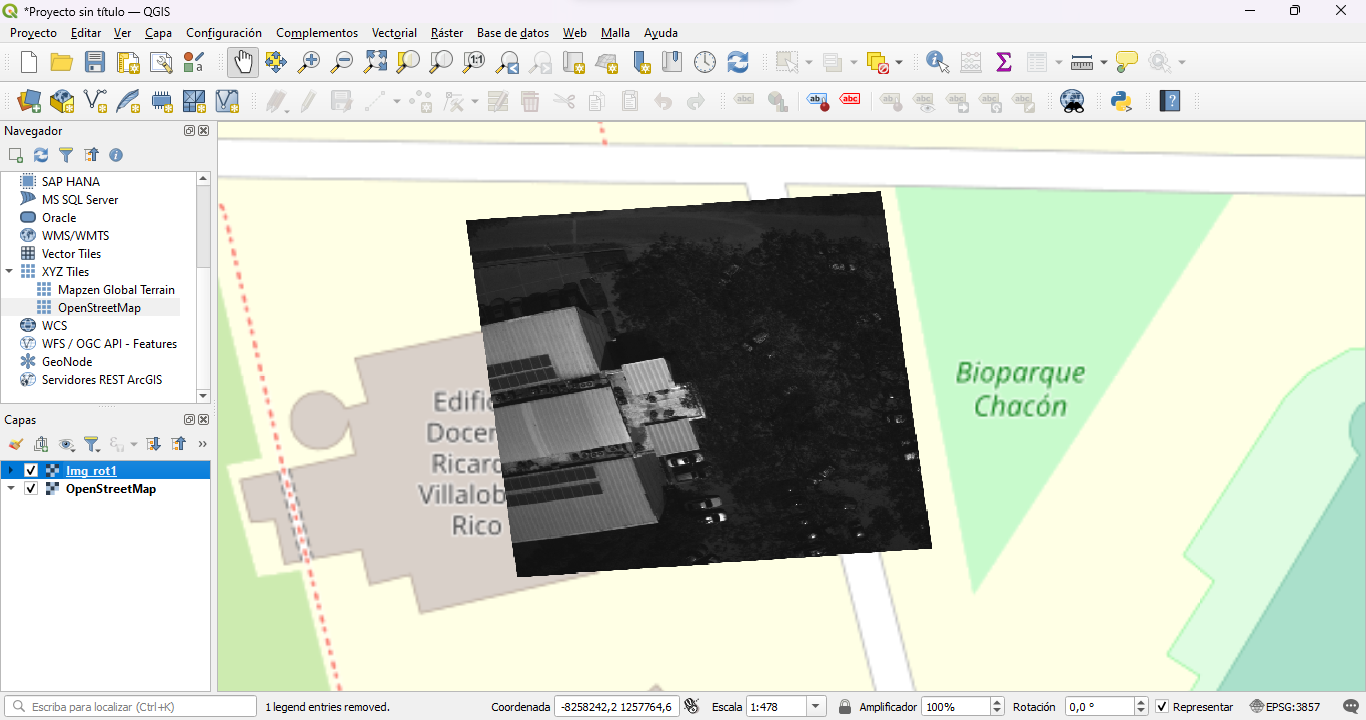